In [1]:
##
#% matplotlib notebook


import matplotlib
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as manimation

import matplotlib.tri as mtri

from scipy.integrate import odeint
from scipy.integrate import complex_ode
import scipy.spatial.distance
import scipy
import scipy.interpolate
import scipy.signal


In [2]:
def image_contour(ax, field, extent,
    label=None, levels=None, cmap='viridis', colors=None, aspect='auto',
    do_imshow=False,
    do_remove_extreme=False,
 
    # Like (batch_qp[:, 0], batch_qp[:, 1]))
    training_data=None,
 
    scatter_kw=dict(color='black', s=24, label='sample training batch'),
 
    **kw_imshow
    ):
    fig = ax.figure
 
    if do_imshow:
        imshow = ax.imshow(field, extent=extent, origin='lower', cmap=cmap, aspect='auto', **kw_imshow)
 
        if colors is None: colors = 'white'
 
    contour = ax.contour(field, extent=extent, levels=levels, colors=colors, linewidths=4)
 
    if do_imshow:
        mappable = imshow
    else:
        mappable = contour
 
    fig.colorbar(
        mappable,
        label=label,
        ax=ax
    )
 
    if training_data is not None:
        ax.scatter(*training_data, **scatter_kw)
         
    if do_remove_extreme:
        kw = do_remove_extreme if isinstance(do_remove_extreme, dict) else {}
        field = remove_extreme(field, **kw)

In [3]:


class GaussianProcess():

    def llmin(x,fx,noise,NT=20):
        """ log likelihood minimization. does not need an initialized process. """

        # full grid approach over several scales
        thetas = np.linspace(-5,5,NT)
        lls = np.zeros(thetas.shape)
        for k in range(NT):
            try:
                gpr = GaussianProcess(x,
                                      fx,
                                      10**thetas[k],
                                      output_noise_std=noise)
                lls[k] = gpr.get_ll()
            except Exception:
                lls[k] = -9999

        p = scipy.interpolate.interp1d(thetas, -lls, fill_value=(np.min(-lls),np.max(-lls)), bounds_error=False)
        res = scipy.optimize.minimize_scalar(p, method="bounded", bounds=[np.min(thetas),np.max(thetas)])

        if not(res.success):
            print("Theta optimization did not converge")
            raise("Theta optimization did not converge")

        return 10**res.x, 10**thetas, lls

    def matern_kernel_v12(x,y,theta):
        if(len(x.shape)==1):
            x = x.reshape(1,-1)
        if(len(y.shape)==1):
            y = np.reshape(1,-1)
        
        distMatrix = scipy.spatial.distance.cdist(x,y, 'euclidean')
        return np.exp(-np.array(distMatrix)/(theta))
    
    def gaussian_kernel(x,y,theta):
        if(len(x.shape)==1):
            x = x.reshape(1,-1)
        if(len(y.shape)==1):
            y = y.reshape(1,-1)
        
        if (isinstance(theta, np.ndarray) and (len(theta.shape) > 1)):
            for k in range(x.shape[1]):
                x[:,k] = x[:,k] / np.sqrt(theta[k])
                y[:,k] = y[:,k] / np.sqrt(theta[k])
        else:
            x = x / np.sqrt(theta)
            y = y / np.sqrt(theta)
        
        distMatrix = scipy.spatial.distance.cdist(x,y, 'euclidean')
        return np.exp(-np.array(distMatrix)**2)
    
    def gaussian_kernel_grad(xx,yy,theta):
        """ computes the gradient of the kernel w.r.t. the first argument """
        x = xx.copy()
        y = yy.copy()
        if(len(x.shape)==1):
            x = x.reshape(1,-1)
        if(len(y.shape)==1):
            y = y.reshape(1,-1)
        
        if (isinstance(theta, np.ndarray) and (len(theta) > 1)):
            for k in range(x.shape[1]):
                x[:,k] = x[:,k] / np.sqrt(theta[k])
            for k in range(y.shape[1]):
                y[:,k] = y[:,k] / np.sqrt(theta[k])
        else:
            x = x / np.sqrt(theta)
            y = y / np.sqrt(theta)

        distMatrix = scipy.spatial.distance.cdist(x,y, 'euclidean')
        kxy = np.exp(-np.array(distMatrix)**2)

        xmy = np.zeros((x.shape[1],x.shape[0],y.shape[0]))
        if x.shape[1] == 1:
            xm = np.dot(xx,np.ones(y.shape).T)
            ym = np.dot(yy,np.ones(x.shape).T).T
            xmy[0,:,:] = xm-ym
        else:
            for k in range(x.shape[1]):
                xm = np.dot(xx[:,k].reshape(-1,1),np.ones((1,yy.shape[0])))
                ym = np.dot(yy[:,k].reshape(-1,1),np.ones((1,xx.shape[0]))).T
                xmy[k,:,:] = xm-ym

        res = np.zeros((x.shape[1], distMatrix.shape[0], distMatrix.shape[1]))
        for k in range(res.shape[0]):
            distMatrixK = xmy
            if (isinstance(theta, np.ndarray) and (len(theta) > 1)):
                res[k,:,:] = -2/(theta[k]) * kxy * np.array(distMatrixK[k,:])
            else:
                res[k,:,:] = -2/(theta) * kxy * np.array(distMatrixK[k,:])
        return res

    def __init__(self,
                 data: np.array,
                 fdata: np.array,
                 theta: np.array,
                 kernel = gaussian_kernel,
                 kernel_grad = gaussian_kernel_grad,
                 output_noise_std = 1e-5,
                 rcond = 1e-10, # used in lstsq
                 verbose=False) -> None:
        """ sets up the gaussian process on a list of points """
        data = data.copy()
        if(len(data.shape)==1):
            data = data.reshape(-1,1)
            
        self.__data = data
        self.__fdata = fdata
        self.__theta = theta
        self.__kernel = kernel
        self.__kernel_grad = kernel_grad
        self.__initialized = True
        self.__output_noise_std = output_noise_std
        self.__rcond = rcond
        
        if verbose and output_noise_std < 1e-5:
            print('Output noise std set to',output_noise_std,'which might cause matrices to become non-positive definite.')
        
        if not(self.__fdata is None):
            self.__alpha, self.__L, self.__ll = self.data_cov(output_noise_std, verbose)
        
    def get_ll(self):
        return self.__ll
    
    def data_cov(self, 
                 output_noise_std,
                 verbose):
        if (self.__initialized is None):
            raise ValueError('Must initialize first')
        k_xx = self.__kernel(self.__data,self.__data, self.__theta) + \
               output_noise_std**2 * np.identity(self.__data.shape[0])
        
        L = np.linalg.cholesky(k_xx)
        alpha0,res0,_,_ = np.linalg.lstsq(L, self.__fdata, rcond=self.__rcond)
        alpha,res,_,_ = np.linalg.lstsq(L.T, alpha0, rcond=self.__rcond)

        logLikelihood = -1/2*np.dot(self.__fdata.T, alpha) \
                        - np.sum(np.log(np.diag(L))) \
                        - L.shape[0]/2*np.log(2*np.pi)
        
        return alpha, L, np.array(logLikelihood).flatten()[0]
    
    def sample(self, xnew: np.array):
        m,std = self.predict(xnew)
        u = np.random.randn(xnew.shape[0],xnew.shape[1])
        L = np.linalg.cholesky(std+1e-5*self.__theta*np.identity(std.shape[0]))
        fnew= m+np.dot(L,u)
        return fnew
        
    def predict(self, xnew: np.array):
        if (self.__initialized is None):
            raise ValueError('Must initialize first')
        xnew = xnew.copy()
        if(len(xnew.shape)==1):
            xnew = x.reshape(1,-1)
            
        k_xxs = self.__kernel(self.__data,xnew, self.__theta)
        
        mean = np.dot(k_xxs.T, self.__alpha)
        
        k_xsxs = self.__kernel(xnew,xnew, self.__theta)
        
        v,_,_,_ = np.linalg.lstsq(self.__L, k_xxs, rcond=self.__rcond)
        std = k_xsxs - np.dot(v.T, v)
        
        return mean, std
        
    def predict_grad(self, xnew: np.array, dx=1e-8) -> None:
        if (self.__initialized is None):
            raise ValueError('Must initialize first')
        if(len(xnew.shape)==1):
            xnew = xnew.reshape(1,-1)
            
        if 1==1:
            k_xxs = self.__kernel_grad(self.__data,xnew, self.__theta)
            mean_grad = np.zeros((xnew.shape[0],xnew.shape[1]))

            for k in range(k_xxs.shape[0]):
                kxxx = np.dot(k_xxs[k,:,:].T, self.__alpha)
                mean_grad[:,k] = kxxx
        else:
            mean_grad = np.zeros((xnew.shape[0],xnew.shape[1]))
            for k in range(xnew.shape[1]):
                v1 = np.array(xnew)
                v1[:,k] = v1[:,k] - dx
                v2 = np.array(xnew)
                v2[:,k] = v2[:,k] + dx
                m1,_ = self.predict(v1)
                m2,_ = self.predict(v2)
                mean_grad[:,k] = (m2-m1)/(2*dx)
        
        return mean_grad
    
    def solve(self, x0, f0, xnew, gnew, solver_tolerance=1e-5, verbose=False):
        """ solve d/dx[f](ynew)=g(ynew) for f """
        if(len(xnew.shape)==1):
            xnew = xnew.reshape(1,-1)
        if(len(gnew.shape)==1):
            gnew = gnew.reshape(1,-1)
        if(len(x0.shape)==1):
            x0 = x0.reshape(1,-1)
            
        # self.__data = np.row_stack([self.__data, x0])
        
        k_xx = self.__kernel(self.__data,self.__data, self.__theta) +\
               self.__output_noise_std**2 * np.identity(self.__data.shape[0])
        # k_xxinv = np.linalg.pinv(k_xx, rcond=self.__rcond)
        
        k_x0x = self.__kernel(x0,self.__data, self.__theta)
        
        # print(k_x0x)
        
        # L = np.linalg.cholesky(k_xx)
        # alpha0,res0,_,_ = np.linalg.lstsq(L, self.__fdata, rcond=self.__rcond)
        
        k_grad =self.__kernel_grad(xnew, self.__data, self.__theta)
        
        mean_grad = np.zeros((xnew.shape[0]*xnew.shape[1],self.__data.shape[0]))

        for k in range(k_grad.shape[0]):
            #kxxx = np.dot(k_grad[k,:,:], k_xxinv)
            kxxx = np.linalg.lstsq(k_xx.T, k_grad[k,:,:].T, rcond=solver_tolerance)[0].T
            if verbose:
                print('kxxx',kxxx.shape)
            mean_grad[(k*xnew.shape[0]):((k+1)*xnew.shape[0]),:] = kxxx
        
        gnew = gnew.reshape(-1,1)
        
        if verbose:
            print('gnew',gnew.shape)
            print('k_xx',k_xx.shape)
            print('k_x0x',k_x0x.shape)
            print('k_grad',k_grad.shape)
            print('mean_grad',mean_grad.shape)
            print('f0',f0.shape)
        
        kx0xkinv = np.linalg.lstsq(k_xx.T, k_x0x.T, rcond=solver_tolerance)[0].T
        mean_grad = np.row_stack([mean_grad, kx0xkinv])
        gnew = np.row_stack([gnew,f0])
        
        if verbose:
            print('mean_grad',mean_grad.shape)
            print('gnew',gnew.shape)
            
        fx,residuals,rank,singularValues = np.linalg.lstsq(mean_grad, gnew, rcond=self.__rcond)
        # fx,residuals,rank,singularValues = np.linalg.lstsq(L, a0, rcond=self.__rcond)
        
        if verbose:
            print('fx',fx.shape)
        #print('rank',rank)
        # print('residuals',residuals)
        #print('singularValues',singularValues)
        
        # fx = fx[0:-(x0.shape[0])]
        
        return (fx)

theta= 0.3
x0,f0 =  [[ 0. ]
 [-0.5]
 [ 0.9]] [[-0.5       ]
 [-0.65112288]
 [-0.50674922]]
x0,f0 =  (3, 1) (3, 1)
xx,yy (13, 1) (15, 1)


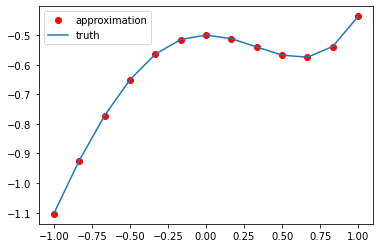

In [4]:
# try solving d/dx f(x) = g(x)

def solution1(x):
    return x**3/3-x**2/2-1/2*np.cos(x**2)
def g1(x):
    return x**2-x+np.sin(x**2)*x

np.random.seed(123495)

noise = 1e-8
N = 15
K = 13
x = np.linspace(-1,1,K).reshape(K,1)+np.random.randn(K,1)*noise*1e-3
y = np.linspace(-1,1,N).reshape(N,1)+np.random.randn(N,1)*noise*1e-3
gy = g1(y)
theta = 0.3
x0 = np.array([0,-.5,.9]).reshape(-1,1)
f0 = solution1(x0)

print('theta=',theta)
print('x0,f0 = ', x0, f0)
print('x0,f0 = ', x0.shape, f0.shape)
print('xx,yy', x.shape, y.shape)

gp = GaussianProcess(x,None,theta=theta,output_noise_std=noise)
fx = gp.solve(x0,f0,y,gy,solver_tolerance=1e-8)

fig = plt.figure()
plt.plot(x,(fx),'ro',markevery=1,label='approximation');
plt.plot(x,solution1(x),label='truth');
plt.legend()

In [5]:
# try solving d/dx f(x) = g(x)

def solution1(x):
    return x[:,1]**2/2+(1-np.cos(x[:,0]))
def g1(x):
    return np.array([np.sin(x[:,0]),x[:,1]])

np.random.seed(123495)

noise = 1e-5
N1,N2 = 100,40
K = 25
train_x = np.linspace(-2*np.pi,2*np.pi,K)+np.random.randn(K,)*noise*1e-3
train_y = np.linspace(-1,1,K)+np.random.randn(K,)*noise*1e-3

test_x = np.linspace(-9,9,N1)+np.random.randn(N1,)*noise*1e-3
test_y = np.linspace(-1.5,1.5,N2)+np.random.randn(N2,)*noise*1e-3

#test_x = np.linspace(-2*np.pi,2*np.pi,N1)+np.random.randn(N1,)*noise*1e-3
#test_y = np.linspace(-1,1,N2)+np.random.randn(N2,)*noise*1e-3


#x0=y0
xx1,xx2 = np.meshgrid(test_x,test_y)
yy1,yy2 = np.meshgrid(train_x,train_y)

x = np.column_stack([xx1.flatten(), xx2.flatten()])
y = np.column_stack([yy1.flatten(), yy2.flatten()])

print(np.min(x[:,0]))

#x = np.random.rand(N*N,2) * 8 - 4
yr = np.zeros((K*K,2))
yr[:,0] = np.random.uniform(low=np.min(train_x), high=np.max(train_x), size=(K*K))
yr[:,1] = np.random.uniform(low=np.min(train_y), high=np.max(train_y), size=(K*K))
y = yr

gy = g1(y)
#theta = np.array([1/N1 * (np.max(x[:,0])-np.min(x[:,0])), 1/N2 * (np.max(x[:,1])-np.min(x[:,1]))])*3.0
theta = 4
#theta = np.array([1/N * (np.max(y[:,0])-np.min(y[:,0])), 1/K * (np.max(y[:,1])-np.min(y[:,1]))])*3.0
print('theta', theta)
x00 = np.array([.5,.4]).reshape(1,-1)#np.random.rand(1,x.shape[1])
#for k in range(x.shape[1]):
#    x00[:,k] = x00[:,k] * (np.max(x[:,k])-np.min(x[:,k])) + np.min(x[:,k])
    
f0 = solution1(x00)

thetas = np.linspace(10,20,2)

if False:
    for k in range(len(thetas)):
        #theta = (thetas[k])
        gp = GaussianProcess(x,None,theta=theta,output_noise_std=noise)
        fx = gp.solve(x00,f0,y,gy,solver_tolerance=1e-6)

        print(theta, np.mean((fx-solution1(x))**2))
else:
    gp = GaussianProcess(y,None,theta=theta,output_noise_std=noise)
    fy = gp.solve(x00,f0,y,gy,solver_tolerance=1e-6)
    gp = GaussianProcess(y,fdata=fy,theta=theta,output_noise_std=noise)
    fx,_ = gp.predict(x)


-8.999999980918743
theta 4


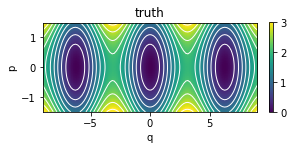

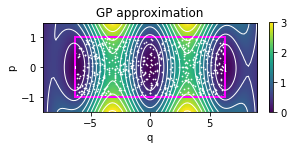

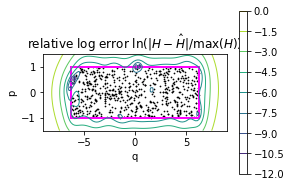

In [6]:
figsize2 = (11*3/4/2,4*3/4)
figsize1 = (5.5*3/4,4*3/4)
asp = 2.5

data = solution1(x).reshape((N2,N1))

fig,ax = plt.subplots(1,1,figsize=figsize2,sharey=True)
ax=[ax]
#plt.imshow(x,(fx),'ro',markevery=1,label='approximation');
ex = [np.min(x[:,1]),np.max(x[:,1]),np.min(x[:,0]), np.max(x[:,0])]
ey = [np.min(x[:,0]),np.max(x[:,0]),np.min(x[:,1]), np.max(x[:,1])]
exy = [np.min(y[:,1]),np.max(y[:,1]),np.min(y[:,0]), np.max(y[:,0])]
eyx = [np.min(y[:,0]),np.max(y[:,0]),np.min(y[:,1]), np.max(y[:,1])]
im1 = ax[0].imshow(solution1(x).reshape((N2,N1)),extent=ey,origin='lower',vmin=0,vmax=3);
ax[0].contour(test_x,test_y,solution1(x).reshape((N2,N1)),10,colors='white',extent=ex,linewidths=1);
#ax[0].scatter(x[:,0],x[:,1],s=.5,c='r')
ax[0].set_title('truth')
#ax[0].set_aspect(1)
ax[0].set_ylabel('p')
ax[0].set_xlabel('q')
ax[0].set_aspect(asp)

im_ratio = data.shape[0]/data.shape[1]
fig.colorbar(im1, fraction=0.049*im_ratio, pad=0.05)

#fig.tight_layout()
fig.savefig('GP_truth.pdf')


rect = matplotlib.patches.Rectangle((train_x[0],train_y[0]),train_x[-1]-train_x[0],train_y[-1]-train_y[0],linewidth=2,edgecolor='magenta',facecolor='none')

fig,ax = plt.subplots(1,1,figsize=figsize2,sharey=True)
ax=[ax]
im1 = ax[0].imshow(np.clip(fx.reshape((N2,N1)),0,4),extent=ey,origin='lower',vmin=0,vmax=3);
ax[0].contour(test_x,test_y,np.clip(fx.reshape((N2,N1)),0,4),10,colors='white',extent=exy,origin='lower',linewidths=1);
ax[0].scatter(y[:,0],y[:,1],s=.5,c='white')
ax[0].add_patch(rect)
ax[0].set_aspect(asp)

#ax[1].contour(test_x,test_y,solution1(x).reshape((N2,N1)),15,extent=exy,origin='lower',vmin=-1,vmax=1);
ax[0].set_title('GP approximation')
#ax[1].set_ylim(exy[2:4])
#ax[1].set_xlim(exy[0:2])
ax[0].set_ylabel('p')
ax[0].set_xlabel('q')

fig.colorbar(im1, fraction=0.049*im_ratio, pad=0.05)
#fig.tight_layout()
fig.savefig('GP_approximation.pdf')

fig,ax = plt.subplots(1,1,figsize=figsize1)
ax=[ax]
#plt.imshow(x,(fx),'ro',markevery=1,label='approximation');
ex = [np.min(x[:,1]),np.max(x[:,1]),np.min(x[:,0]), np.max(x[:,0])]
exy = [np.min(y[:,1]),np.max(y[:,1]),np.min(y[:,0]), np.max(y[:,0])]
sc1=ax[0].contour(test_x,test_y,np.log(np.abs(solution1(x).reshape((N2,N1))-fx.reshape((N2,N1)))/np.max(solution1(x))),
                  10,extent=ex,linewidths=1);
ax[0].set_title(r'relative log error $\ln(\|H-\hat H\|/\max(H))$')
rect = matplotlib.patches.Rectangle((train_x[0],train_y[0]),train_x[-1]-train_x[0],train_y[-1]-train_y[0],linewidth=2,edgecolor='magenta',facecolor='none')
ax[0].add_patch(rect)
ax[0].scatter(y[:,0],y[:,1],s=.5,c='k')
ax[0].set_ylabel('p')
ax[0].set_xlabel('q')
ax[0].set_aspect(asp)

## imshow + contour plot on top of it

fig.colorbar(sc1)
#fig.tight_layout()
fig.savefig('GP_approximation_error.pdf')

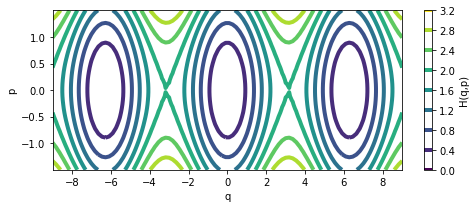

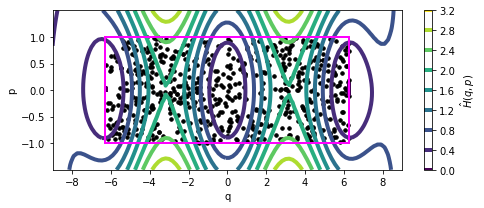

In [7]:
field1 = data
field2 = np.clip(fx.reshape((N2,N1)),0,4)
extent = ey
figsize = (7,3)

np.savez('hamiltonian_GP_data.npz', field1=field1, field2=field2, training_data_GP=y)

fig,ax = plt.subplots(1,1,figsize=figsize,sharey=True)

image_contour(ax, field1, extent,\
    label='H(q,p)', levels=None, cmap='viridis', colors=None, aspect=2.5,\
    do_imshow=False,\
    do_remove_extreme=False,\
    training_data=None,\
    scatter_kw=dict(color='black', s=12, label='sample training batch'))
ax.set_ylabel('p')
ax.set_xlabel('q')
fig.tight_layout()
fig.savefig('GP_truth.pdf')

fig,ax = plt.subplots(1,1,figsize=figsize,sharey=True)

image_contour(ax, field2, extent,\
    label='$\hat H(q,p)$', levels=None, cmap='viridis', colors=None, aspect=2.5,\
    do_imshow=False,\
    do_remove_extreme=False,\
    training_data=y.T,\
    scatter_kw=dict(color='black',s=12, label='sample training batch'))
rect = matplotlib.patches.Rectangle((train_x[0],train_y[0]),train_x[-1]-train_x[0],train_y[-1]-train_y[0],zorder=2,linewidth=2,edgecolor='magenta',facecolor='none')
ax.add_patch(rect)
ax.set_ylabel('p')
ax.set_xlabel('q')
fig.tight_layout()
fig.savefig('GP_approximation.pdf')

In [8]:
npzd = np.load('hamiltonian_GP_data.npz')
for k in npzd.keys():
    print(k)
    
print(npzd['field1'].shape)

field1
field2
training_data_GP
(40, 100)


[-6.26697164 -0.99403356]
(625, 1)
(625,)
train error:  2.191336447990886e-05
test error:   3.5254046185103415e-05


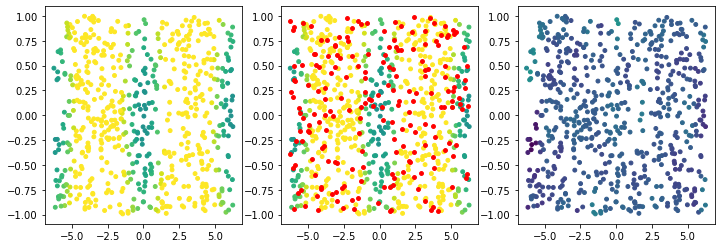

In [9]:
# compute mean squared loss to test and validation
x_train = y.copy()
print(np.min(y,axis=0))
np.random.seed(1)
x_validate = np.random.uniform(low=np.min(y,axis=0),\
                               high=np.max(y,axis=0), size=(200,2))

fx_train_approx,_ = gp.predict(x_train+np.random.randn(x_train.shape[0],2)*1e-10)
fx_train_true = solution1(x_train)
fx_validate_approx,_ = gp.predict(x_validate+np.random.randn(x_validate.shape[0],2)*1e-10)
fx_validate_true = solution1(x_validate)

print(fx_train_approx.shape)
print(fx_train_true.shape)

print('train error: ', str(np.mean((fx_train_approx.ravel()-fx_train_true)**2)))
print('test error:  ', str(np.mean((fx_validate_approx.ravel()-fx_validate_true)**2)))

fig,ax=plt.subplots(1,3,figsize=(12,4))
ax[0].scatter(*x_train.T, s=15,c=fx_train_approx.ravel(),vmax=1,vmin=-1)
ax[1].scatter(*x_train.T, s=15,c=fx_train_true.ravel(),vmax=1,vmin=-1)
ax[1].scatter(*x_validate.T, s=15,c='r')
ax[2].scatter(*x_train.T, s=15,c=(fx_train_approx.ravel()-fx_train_true),vmax=.01,vmin=-.01)

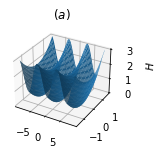

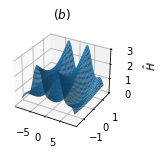

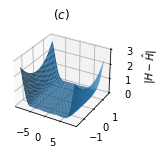

In [10]:
def plot_data():
    zl = [0,3]
    # figure 1: 3d plots of the reconstructed functions and error
    
    fig = plt.figure(figsize=(3,2))
    ax = fig.add_subplot(111,projection='3d')
    ax.plot_surface(xx1,xx2,solution1(x).reshape((N2,N1)))
    ax.set_zlim(zl)
    ax.set_title(r'$(a)$')
    ax.set_zlabel(r'${H}$')
    fig.subplots_adjust(right=0.85)
    fig.savefig('H_GP_true.png')
    
    fig = plt.figure(figsize=(3,2))
    ax = fig.add_subplot(111,projection='3d')
    ax.plot_surface(xx1,xx2,fx.reshape((N2,N1)))
    ax.set_zlim(zl)
    ax.set_title(r'$(b)$')
    ax.set_zlabel(r'$\hat{H}$')
    fig.subplots_adjust(right=0.85)
    fig.savefig('H_GP_approx.png')
    
    fig = plt.figure(figsize=(3,2))
    ax = fig.add_subplot(111,projection='3d')
    ax.plot_surface(xx1,xx2,
                    np.abs(solution1(x).reshape((N2,N1)) - fx.reshape((N2,N1))))
    ax.set_zlim(zl)
    ax.set_title(r'$(c)$')
    ax.set_zlabel(r'$|{H}-\hat{H}|$')
    fig.subplots_adjust(right=0.85)
    #fig.tight_layout()
    fig.savefig('H_GP_error.png')
    
    if False:

        # figure 2: time derivative of approximated H
        dHdqp = np.gradient(solution1(x).reshape((N1,N2)).T,x0[2]-x0[1])
        dHdq = dHdqp[0]
        dHdp = dHdqp[1]
        dHdt = np.array(dHdq) - np.array(x[:,1].reshape((N1,N2)))
        print(dHdt.shape)
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111,projection='3d')
        ax.plot_surface(x[:,0].reshape((N1,N2)),x[:,1].reshape((K,K)),
                        x[:,1].reshape((N1,N2)))
        # ax.set_zlim(zl)
        ax.set_title('time derivative')
        ax.set_zlabel(r'$d\hat{H}/dt$')
    

plot_data()